In [23]:
from AdvSampleUtil import AdvSampleGenerator
from Target_model import MLP_MNIST
from torchvision import datasets
import torch
import torch.nn as nn
from torchvision import transforms
from art.estimators.classification import PyTorchClassifier
import art
from art.attacks.evasion import FastGradientMethod

In [24]:
#GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#加载目标模型
model=MLP_MNIST()
model.load_state_dict(torch.load("E:/Project/ModelAndDataset/model/mnist_mlp.pth"))
model.to(device)
estimator=PyTorchClassifier(model=model,loss=nn.CrossEntropyLoss(),
                            optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
                            input_shape=(1,28,28), 
                            nb_classes=10)
#定义攻击器
attacker = FastGradientMethod(estimator, eps=0.1)
#加载数据
img_transform = transforms.Compose([
    transforms.ToTensor(),])
mnist_test= datasets.MNIST(
    root='E:/Project/ModelAndDataset/data', train=False, transform=img_transform, download=True
)
advSampleGenerator=AdvSampleGenerator(model,mnist_test,attacker,False,device)
samplePairs=advSampleGenerator.generate(1000)

raw_predicted: tensor([7, 2, 1, 0, 4, 1, 4, 3, 6, 9, 0, 8, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 3, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
adv_predicted: tensor([3, 3, 8, 0, 7, 8, 8, 8, 0, 9, 0, 6, 7, 0, 3, 3, 9, 3, 8, 7, 7, 5, 8, 5,
        7, 0, 0, 4, 0, 8, 3, 3, 3, 4, 3, 3, 3, 8, 2, 8, 8, 3, 3, 1, 5, 3, 3, 3,
        8, 7, 3, 3, 0, 3, 8, 0, 4, 8, 9, 7, 3, 2, 8, 2], device='cuda:0')
comparison: tensor([False, False, False,  True, False, False, False, False, False,  True,
         True, False, False,  True, False, False,  True, False, False, False,
        False, False, False,  True, False,  True, False,  True,  True, False,
         True, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False,  True,  True, False,  True, False,
        False, False, 

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

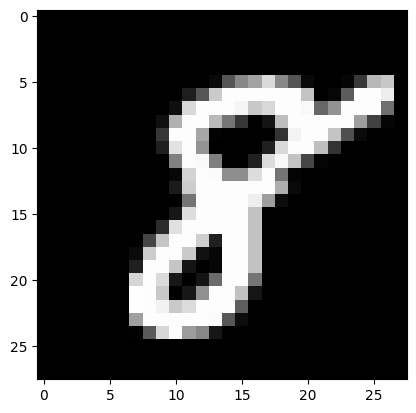

In [25]:
type(samplePairs[0].raw_img)
import matplotlib.pyplot as plt
plt.imshow(samplePairs[0].raw_img,cmap="gray")
samplePairs[0].raw_img


In [26]:
samplePairs[0].raw_label

8.0

3.0

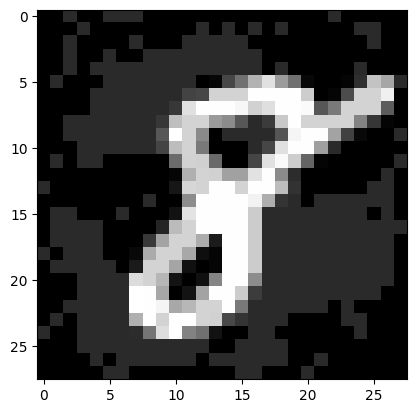

In [27]:
plt.imshow(samplePairs[0].adv_img,cmap="gray")
samplePairs[0].adv_label

In [28]:
from Generator_MNIST import generator_mnistConv,generator_mnist
G=generator_mnist(100)
G.load_state_dict(torch.load('E:/Project/ModelAndDataset/model/generator_CGAN_mnist.pth'))
G = G.to(device)

G2=generator_mnistConv(100)
G2.load_state_dict(torch.load('E:/Project/ModelAndDataset/model/generator_CGAN_mnistconv.pth'))
G2 = G2.to(device)


In [29]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from AdvSampleUtil import EvaluateImage,DrawResult
r_mse_np=np.array([])
r_l2_np=np.array([])
r_ssim_np=np.array([])

a_mse_np=np.array([])
a_l2_np=np.array([])
a_ssim_np=np.array([])
for pair in samplePairs:
    z = torch.randn(100,device=device)
    label_onehot=torch.zeros(10)
    label_onehot[int(pair.adv_label)]=1
    z = torch.cat([z,label_onehot.to(device)],0)
    g_img=G(z).view(1,28,28).detach().squeeze().cpu().numpy()
    r_img=pair.raw_img
    a_img=pair.adv_img
    #评估原始图片与生成图片
    r_mse,r_l2,r_ssim=EvaluateImage(r_img,g_img)
    r_mse_np=np.append(r_mse_np,r_mse)
    r_l2_np=np.append(r_l2_np,r_l2)
    r_ssim_np=np.append(r_ssim_np,r_ssim)
    #评估对抗样本与生成图片
    a_mse,a_l2,a_ssim=EvaluateImage(a_img,g_img)
    a_mse_np=np.append(a_mse_np,a_mse)
    a_l2_np=np.append(a_l2_np,a_l2)
    a_ssim_np=np.append(a_ssim_np,a_ssim)
      
print("MSE:{} L2_distance:{} SSIM:{}".format(np.sum(np.less(r_mse_np,a_mse_np)),
                                             np.sum(np.less(r_l2_np,a_l2_np)),
                                             np.sum(np.greater(r_ssim_np,a_ssim_np))
                                             ))
    
    

MSE:650 L2_distance:650 SSIM:239


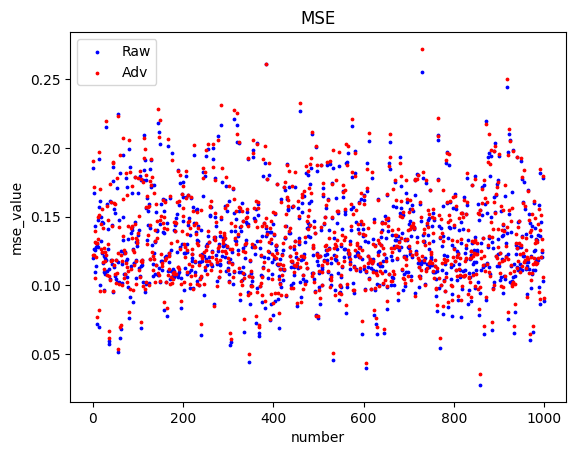

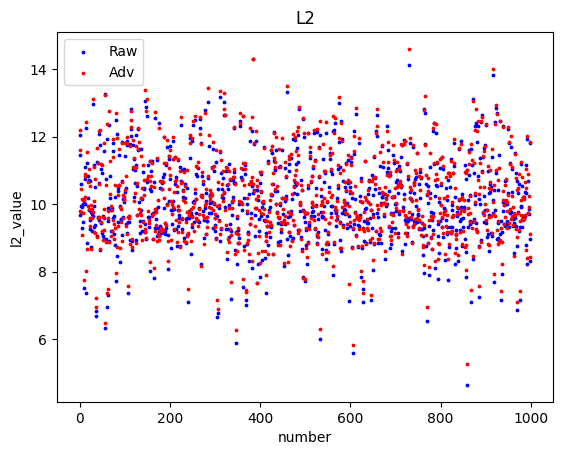

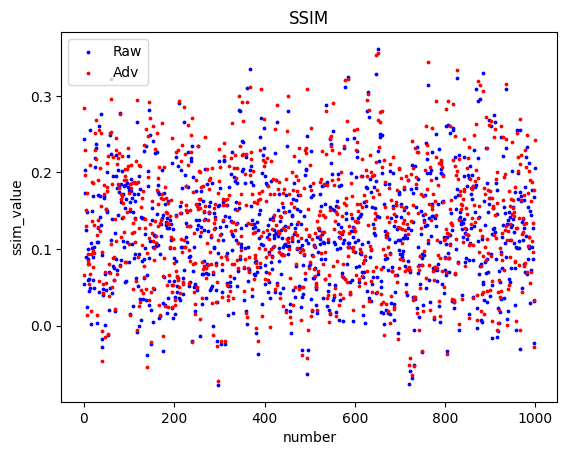

In [30]:
fig1=DrawResult(r_mse_np,a_mse_np,"MSE","number","mse_value")
plt.show(fig1)
fig2=DrawResult(r_l2_np,a_l2_np,"L2","number","l2_value")
plt.show(fig2)
fig3=DrawResult(r_ssim_np,a_ssim_np,"SSIM","number","ssim_value",)
plt.show(fig3)

In [31]:
r_mse_np=np.array([])
r_l2_np=np.array([])
r_ssim_np=np.array([])

a_mse_np=np.array([])
a_l2_np=np.array([])
a_ssim_np=np.array([])
for pair in samplePairs:
    z = torch.randn(100,1,1,device=device)
    label_onehot=torch.zeros(10)
    label_onehot[int(pair.adv_label)]=1
    z = torch.cat([z,label_onehot.unsqueeze(1).unsqueeze(2).to(device)],0)
    g_img=G2(z).view(1,28,28).detach().squeeze().cpu().numpy()
    r_img=pair.raw_img
    a_img=pair.adv_img
     #评估原始图片与生成图片
    r_mse,r_l2,r_ssim=EvaluateImage(r_img,g_img)
    r_mse_np=np.append(r_mse_np,r_mse)
    r_l2_np=np.append(r_l2_np,r_l2)
    r_ssim_np=np.append(r_ssim_np,r_ssim)
    #评估对抗样本与生成图片
    a_mse,a_l2,a_ssim=EvaluateImage(a_img,g_img)
    a_mse_np=np.append(a_mse_np,a_mse)
    a_l2_np=np.append(a_l2_np,a_l2)
    a_ssim_np=np.append(a_ssim_np,a_ssim)

print("MSE:{} L2_distance:{} SSIM:{}".format(np.sum(np.less(r_mse_np,a_mse_np)),
                                             np.sum(np.less(r_l2_np,a_l2_np)),
                                             np.sum(np.greater(r_ssim_np,a_ssim_np))
                                             ))

MSE:584 L2_distance:584 SSIM:858


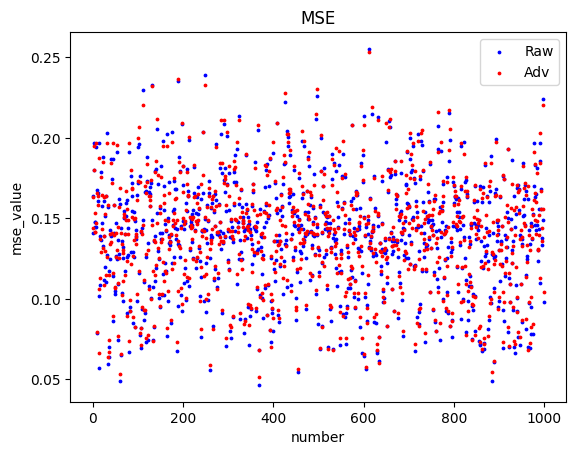

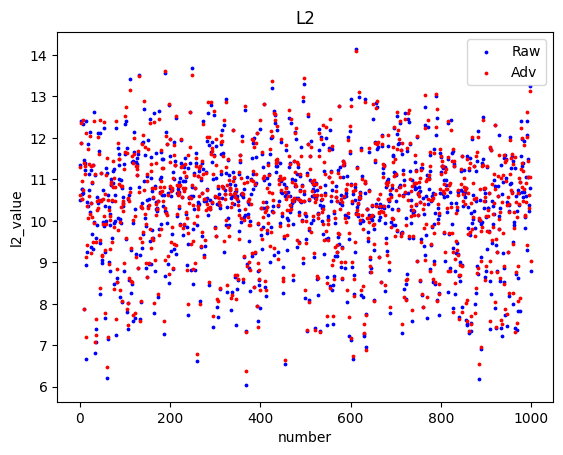

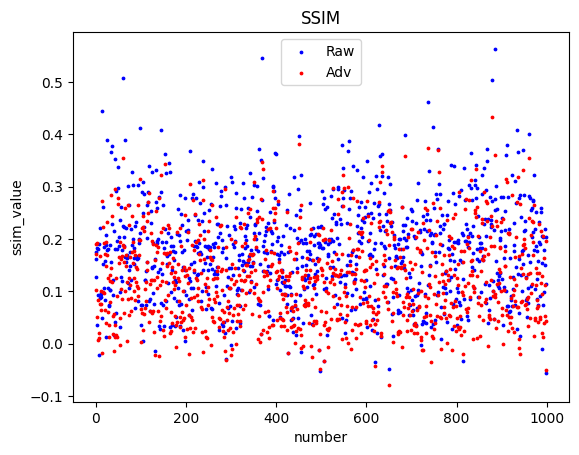

In [32]:
fig1=DrawResult(r_mse_np,a_mse_np,"MSE","number","mse_value")
plt.show(fig1)
fig2=DrawResult(r_l2_np,a_l2_np,"L2","number","l2_value")
plt.show(fig2)
fig3=DrawResult(r_ssim_np,a_ssim_np,"SSIM","number","ssim_value")
plt.show(fig3)